### Goal

Pricing optimization is, non surprisingly, another area where data science can provide huge value. The goal here is to evaluate whether a pricing test running on the site has been successful.

As always, you should focus on user segmentation and provide insights about segments
who behave differently as well as any other insights you might find.

### Challenge Description

Company XYZ sells a software for $\$$39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66 percent of the users have seen the old price ($\$$39), while a random sample of 33 percents users a higher price ($\$$59). The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users. Especially he asked you the following questions:
- 1) **Should the company sell its software for $\$$39 or $\$$59?**
- 2) The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. **What are your main findings looking at the data?**
- 3)[Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

### Data


**test_results** - data about the test

Columns:
- **user_id** : the Id of the user. Can be joined to user_id in user_table
- **timestamp** : the date and time when the user hit for the first time company XYZ
webpage. It is in user local time
- **source** : marketing channel that led to the user coming to the site. It can be:
    ads ["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from
google ads, yahoo ads, etc.
seo - ["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from
google search, yahoo, facebook, etc.
friend_referral : user coming from a referral link of another user
direct_traffic: user coming by directly typing the address of the site on the browser

- **device** : user device. Can be mobile or web operative_system : user operative system. Can be: "windows", "linux", "mac" for web, and "android", "iOS" for mobile. Other if it is none of the above test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old lower price)
- **price** : the price the user sees. It should match test converted : whether the user converted (i.e. 1 -> bought the software) or not (0 -> left the site without buying it).

**user_table** - Information about the user

Columns:
- user_id : the Id of the user. Can be joined to user_id in test_results table
- city : the city where the user is located. Comes from the user ip address
- country : in which country the city is located
- lat : city latitude - should match user city 
- long : city longitude - should match user city

Reference: https://github.com/JifuZhao/DS-Take-Home

In [1]:
import  warnings
warnings.simplefilter('ignore')

import re # regular expression operation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

%matplotlib inline

### Load data

In [2]:
user_table = pd.read_csv('../Pricing_Test/user_table.csv')
user_table.head(5)

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [3]:
user_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
user_id    275616 non-null int64
city       275616 non-null object
country    275616 non-null object
lat        275616 non-null float64
long       275616 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [4]:
user_table.isnull().sum()

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

In [5]:
test_results = pd.read_csv('../Pricing_Test/test_results.csv')
test_results.head(5)

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [6]:
test_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [7]:
test_results.isnull().sum()

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

### Data Preprocessing

In [8]:
print('user_test:\t', user_table['user_id'].unique().shape)
print('test_results:\t', test_results['user_id'].unique().shape)

('user_test:\t', (275616,))
('test_results:\t', (316800,))


In [9]:
# merge this two table on 'user_id'

data = pd.merge(left=test_results, right=user_table, how='left', on='user_id')
data.head(5)

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [10]:
# because of the difference in the sample size of two merged sets, we ended up
# with some null values in the dataset.
data.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64

In [11]:
# We need to be sure that all people who participate in the test (H1) are seeing the correct
# price, which is 59$ and vice-versa.

data[['price', 'user_id','test']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918


Apparently there are some problems with the data

- there are a small amount of users who are labelled with test=0 but actually see price $\$59$
- there are a small amount of users who are labelled with test=1 but actually see price $\$39$.

However, the proportion of such users is quite small, so these samples can be removed.

In [12]:
# data cleaning

data = data[((data['test']==0) & (data['price']==39)) | ((data['test']==1) & (data['price']==59))]

In order to estimate which price should the company keep we create a new feature called `revenue`.

In [13]:
data['revenue'] = data['price'] * data['converted']
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


### EDA

Our first objective is to check whether our test data is totally randomized.
#### Source

In [14]:
# Check randominess
tmp = data.groupby('test')['source'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp

,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
test,,,,,,,,,,,,
0,0.072014,0.186873,0.023761,0.168253,0.095083,0.191154,0.064790,0.006562,0.074502,0.029030,0.021509,0.066468
1,0.072394,0.188706,0.024219,0.169253,0.092786,0.189259,0.066337,0.007154,0.070753,0.029539,0.021814,0.067786


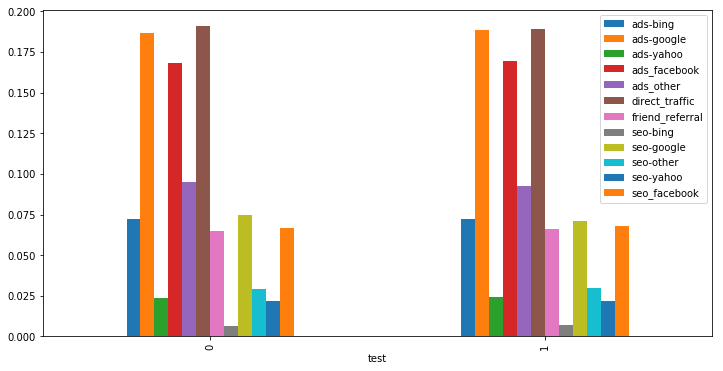

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
tmp.plot(kind='bar', ax=ax)
plt.show()

In [16]:
data[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

,,user_id
test,price,
0,39,202517
1,59,113918


In [17]:
count = data[['source', 'test','revenue']].groupby(['source','test']).count().reset_index()
count.head(5)

,source,test,revenue
0,ads-bing,0,14584
1,ads-bing,1,8247
2,ads-google,0,37845
3,ads-google,1,21497
4,ads-yahoo,0,4812


In [18]:
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517
count.head()

,source,test,revenue
0,ads-bing,0,0.072014
1,ads-bing,1,0.072394
2,ads-google,0,0.186873
3,ads-google,1,0.188706
4,ads-yahoo,0,0.023761


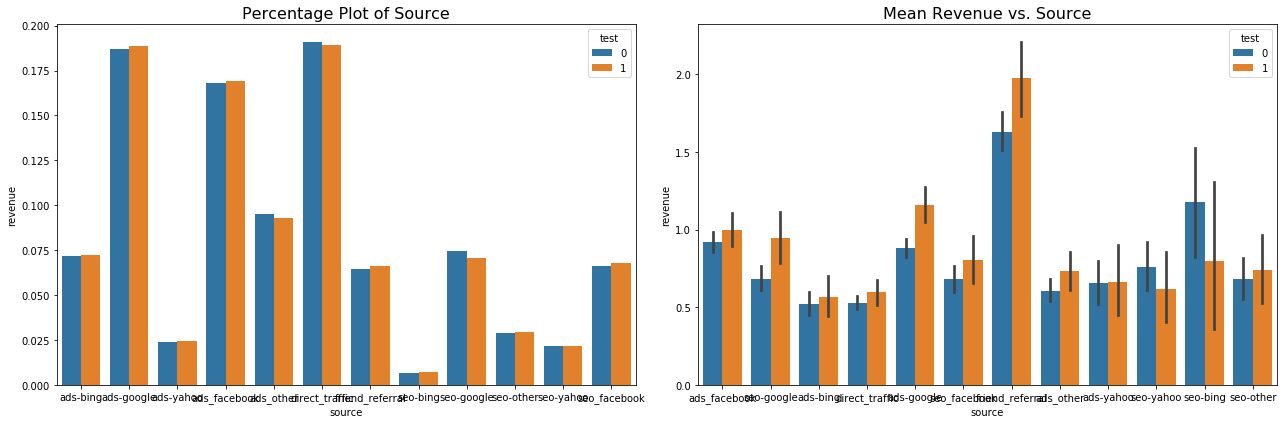

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='source', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Source', fontsize=16)

sns.barplot(x='source', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Source', fontsize=16)
plt.tight_layout()
plt.show()

#### Device

In [20]:
# Perform the same test for randomness for Devices now

# Check randominess
tmp = data.groupby('test')['device'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp

,mobile,web
test,,
0,0.594365,0.405635
1,0.578469,0.421531


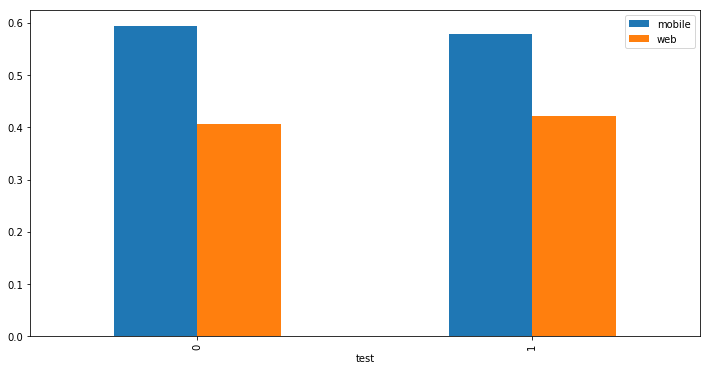

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
tmp.plot(kind='bar', ax=ax)
plt.show()

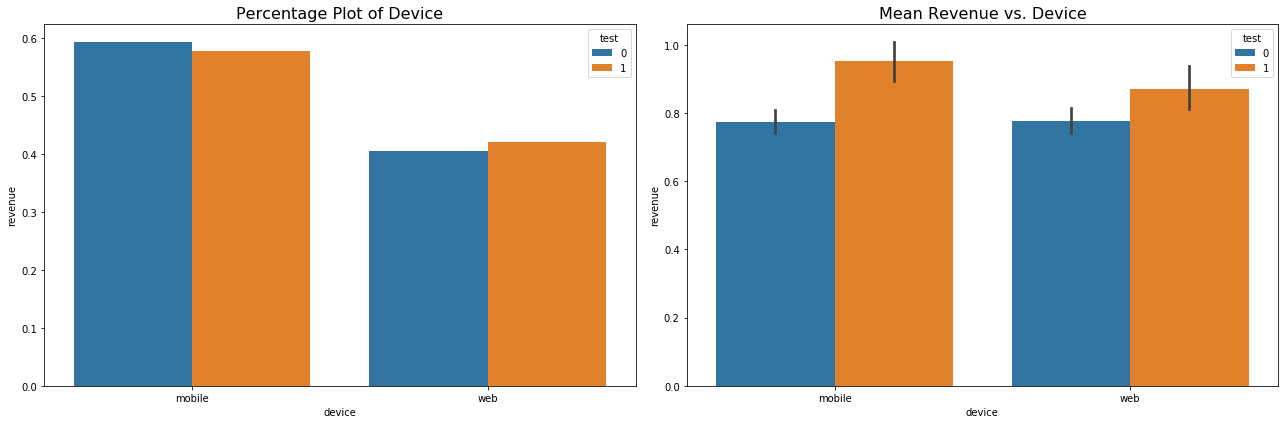

In [22]:
# Visualization of device
count = data[['device', 'test', 'revenue']].groupby(['device', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='device', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Device', fontsize=16)

sns.barplot(x='device', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Device', fontsize=16)
plt.tight_layout()
plt.show()

#### Operating system

In [23]:

# Check randominess
tmp = data.groupby('test')['operative_system'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp

,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313638,0.305125,0.237891,0.080709,0.051754,0.010883
1,0.327718,0.294598,0.234318,0.076459,0.050001,0.016907


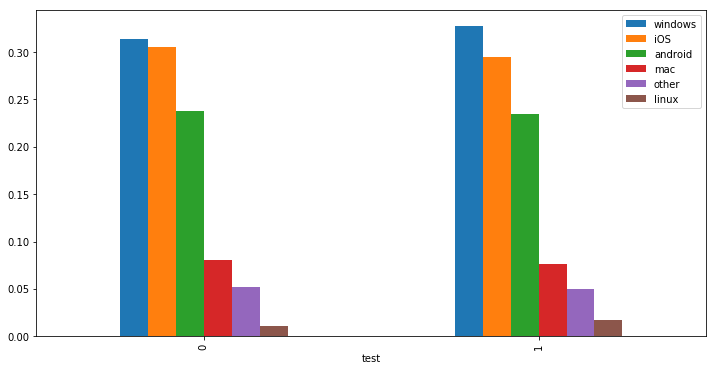

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
tmp.plot(kind='bar', ax=ax)
plt.show()

Very small proportion of Linux users, is everything OK with the interface etc?

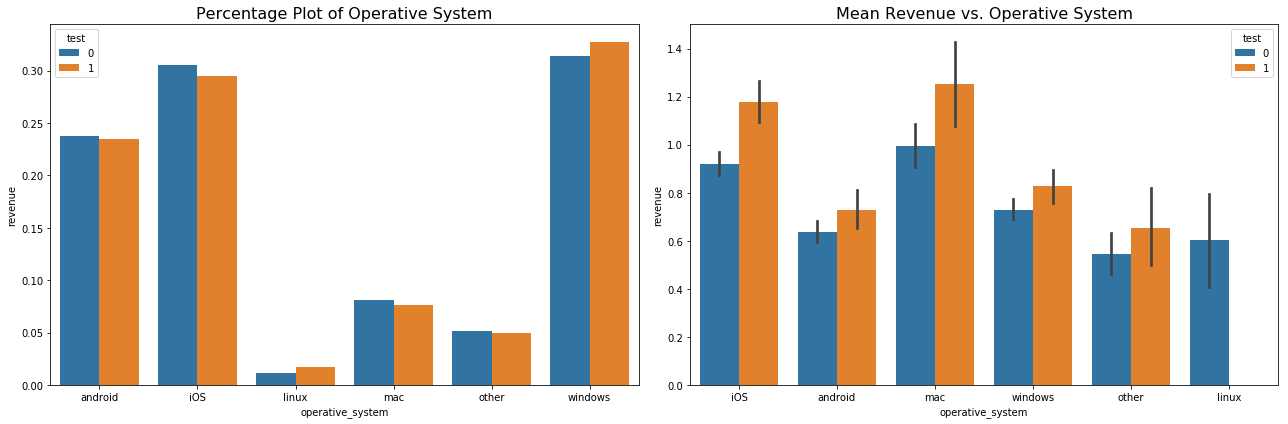

In [25]:
# Visualization of operative system
count = data[['operative_system', 'test', 'revenue']].groupby(['operative_system', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='operative_system', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Operative System', fontsize=16)

sns.barplot(x='operative_system', y='revenue', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Operative System', fontsize=16)
plt.tight_layout()
plt.show()

From above visualizations, we can see that the test is not $100 \%$ randomized, especially `device` and `operative_system`. These factors will influence the robostness of our final conclusions.

### Question 1

**Should the company sell its software for $\$$39 or $\$$59?**

In [26]:
# check the conversion rate for A/B test

data[['test','converted']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


In [27]:
# check the revenue rate for A/B test

data[['test','revenue']].groupby('test').mean()

,revenue
test,
0,0.776083
1,0.917748


Clearly, for those with lower price $\$39$, they have a higher conversion rate $1.990\%$. For those with higher price $\$59$, the conversion rate is $1.556\%$. However, considering the price, the average revenue for higher price ($0.918$) is actually larger than the lower price ($0.776$).

Now, let's conduct hypothesis testing.

- Null hypothesis $H_{0}$: experimental group's average revenue is equal to or less than control group's average revenue
- Alternative hypothesis $H_{1}$: experimental group's average revenue is higher than control group's average revenue

In [28]:
control_values = data[data['test'] == 0]['revenue'].values
experimental_values = data[data['test'] == 1]['revenue'].values

# T-Test
print(ttest_ind(control_values, experimental_values, axis=0, equal_var=False))

Ttest_indResult(statistic=-5.715224666463108, pvalue=1.0972577312420781e-08)



The above t-test is performed in order to determine whether there is any difference in conversion proportions for the two groups. The two groups are 'control', those who have the \$39 software, and 'test', those who have the $59 software. The p-value for the t-test is extremely small, implying that there is indeed a difference. The proportion of the control group that converted is 1.99%, while the proportion of the test group that converted is 1.55%. This is a 21% drop in conversions (1.99-1.55)/1.99=21%.

The above test is actually two tailed test. What we want is one-tailed test. However, from above result, we can easily conclude that even for one-tailed test, we can safely conclude that we can reject the null hypothesis, and conclude that experimental group's average revenue is higher than control group's average revenue.

**T-test reflection**

Are the results of the t-test convincing? It seems questionable that the p-value is basically zero. Some things to investigate are whether enough data is collected and whether people are indeed assigned randomly to the control and test groups (which we establised not to be $100\%$ true).

### Question 2

The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. **What are your main findings looking at the data?**

In [29]:
# So we need to have a look at the data from conversion point of view
# We start with 'Source' - how this client came to our website

data.groupby('source')['converted'].mean().reset_index()

,source,converted
0,ads-bing,0.012001
1,ads-google,0.021502
2,ads-yahoo,0.014793
3,ads_facebook,0.021198
4,ads_other,0.014350
5,direct_traffic,0.012294
6,friend_referral,0.038688
7,seo-bing,0.023787
8,seo-google,0.016978
9,seo-other,0.015686


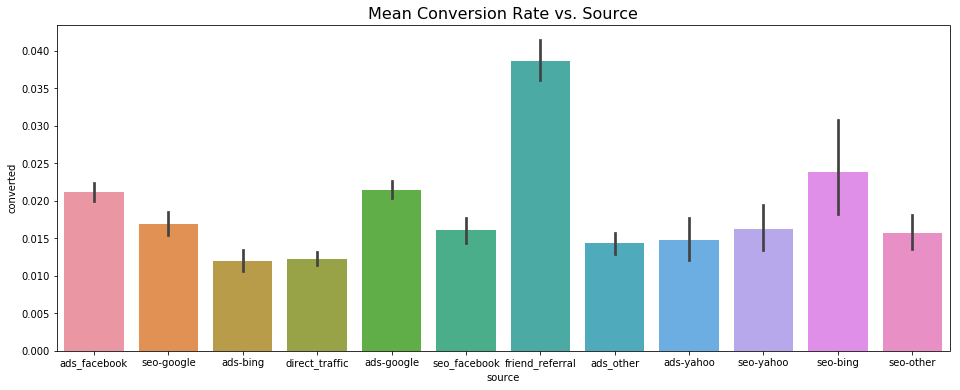

In [30]:
# Visualization of source
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

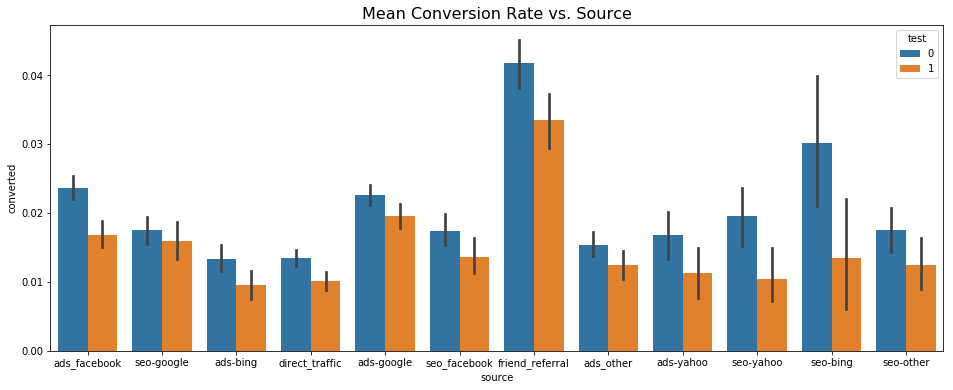

In [31]:
# Visualization of source
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

In [32]:
# Now we continue with 'Device' - user device. Can be mobile or web

data.groupby('device')['converted'].mean().reset_index()

,device,converted
0,mobile,0.018554
1,web,0.018023


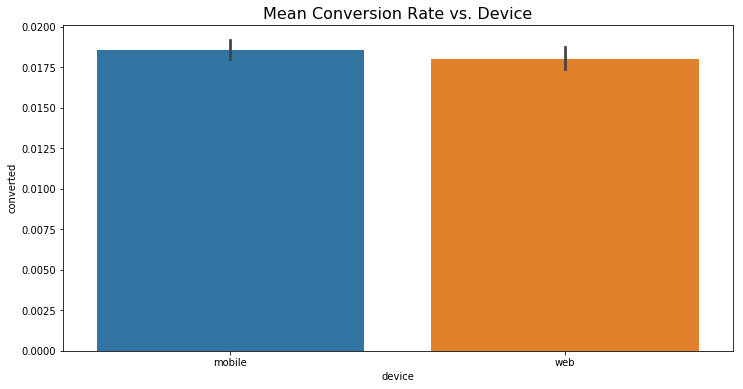

In [33]:
fix, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='device', y='converted', data = data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

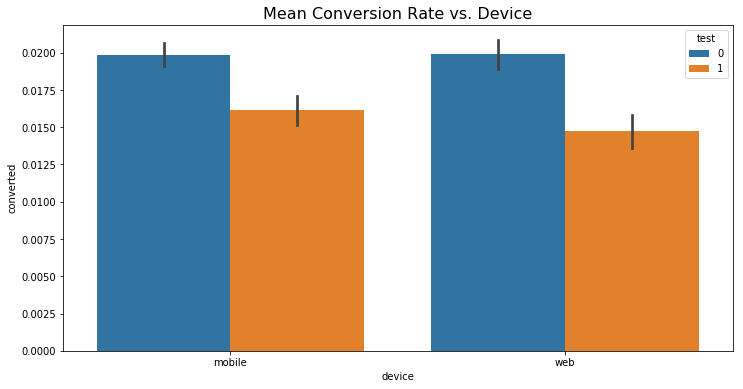

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='device', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

In [35]:
# Let conclude our observation by looking at 'operative system' feature w.r.t. conversion

data.groupby('operative_system')['converted'].mean().reset_index()

,operative_system,converted
0,android,0.014919
1,iOS,0.022328
2,linux,0.008232
3,mac,0.023987
4,other,0.012981
5,windows,0.016966


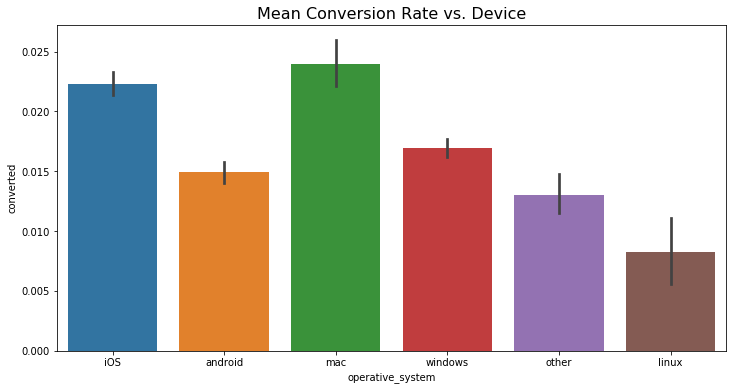

In [36]:
fix, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='operative_system', y='converted', data = data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

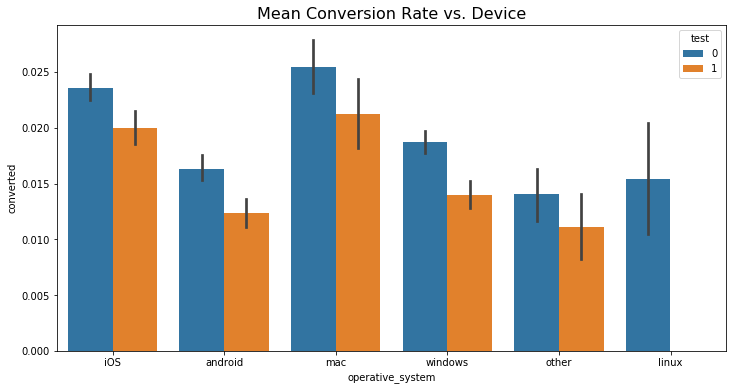

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='operative_system', y='converted', hue='test', data=data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

In [38]:
data[['test', 'converted','revenue']].groupby('test').mean()

,converted,revenue
test,,
0,0.019900,0.776083
1,0.015555,0.917748


From above, we can easily conclude that price dramatically influence the conversion rate. But beside price, there are still other factors that can influence the conversion rate.

- **Source**: Friend-referral users have much higher conversion rate
- **Device** : The influence of device is not significant
- **Operative System**: Mac and ios users have much higher conversion rate

#### Actionable Insights (refer to online resource)

friend's referral, Apple user (MAC or iOS), low price are three great **positive factors** which improve the conversion rate if we want to increase the price, which impacts negatively on conversion rate, we must compensate on the other two factors
- lauch special marketing program targeted to Apple users (MAC or iOS users)
- run some program which rewards user which can invite his/her friend to use our software

Linux users don't like our software as much as users on other OS. **Development team should find out the reason**. For example, is there any incompatibility issue on Linux?

### Question 3 

The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

In order to answer this question we need to find a day when the p-value becomes less than the critical value (0.001), which is I think roughly 5-6 weeks. So the company could stop collecting data after this point, but I think they should decide ahead of time how long the trial should run for.